In [ ]:
figsize('inline_short')

from collections import OrderedDict
import json
from typing import List

from skm import SKM

from util import *

# SKM example

(2, 200)

(2, 200)

(2, 200)

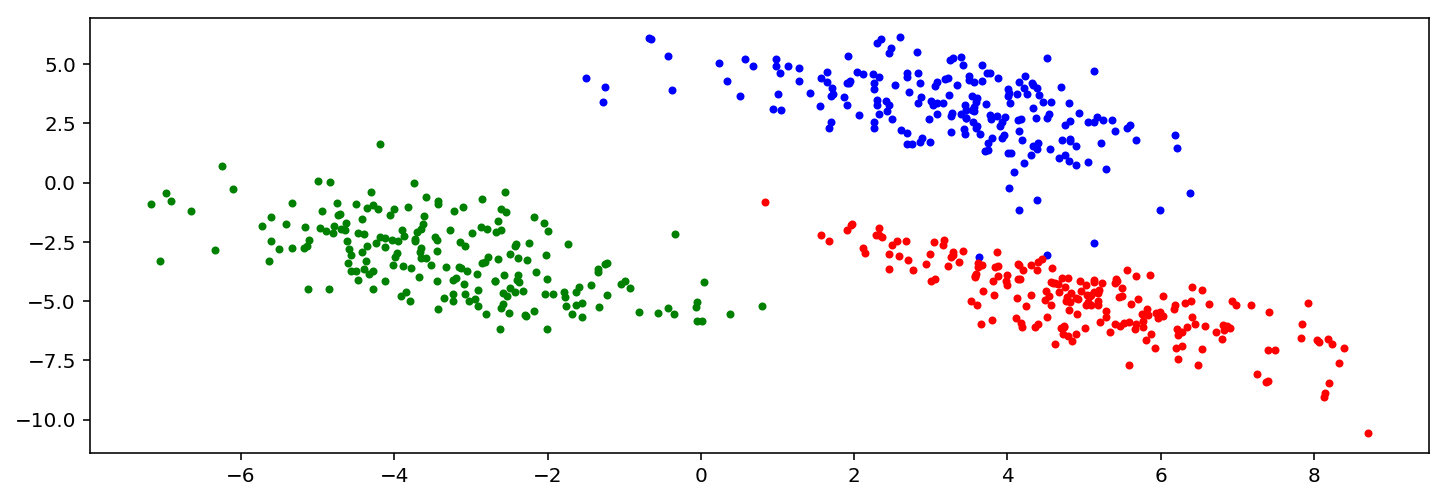

In [ ]:
# Generate training data
#   - skm expects data of the shape (freqs, patches)
npoints = 200
X_train = dict(
    a=np.array(polar_to_cart(
        r=5 + np.random.normal(size=npoints, scale=1),
        theta=np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0),
    )),
    b=np.array(polar_to_cart(
        r=7 + np.random.normal(size=npoints, scale=2),
        theta=-np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/32.0),
    )),
    c=np.array(polar_to_cart(
        r=5 + np.random.normal(size=npoints, scale=1),
        theta=5/4.0  * np.pi + np.random.normal(size=npoints, scale=np.pi/8.0),
    )),
)
display(
    X_train['a'].shape,
    X_train['b'].shape,
    X_train['c'].shape,
)
plt.plot(X_train['a'][0], X_train['a'][1], 'b.')
plt.plot(X_train['b'][0], X_train['b'][1], 'r.')
plt.plot(X_train['c'][0], X_train['c'][1], 'g.')
plt.show()

(2, 600)

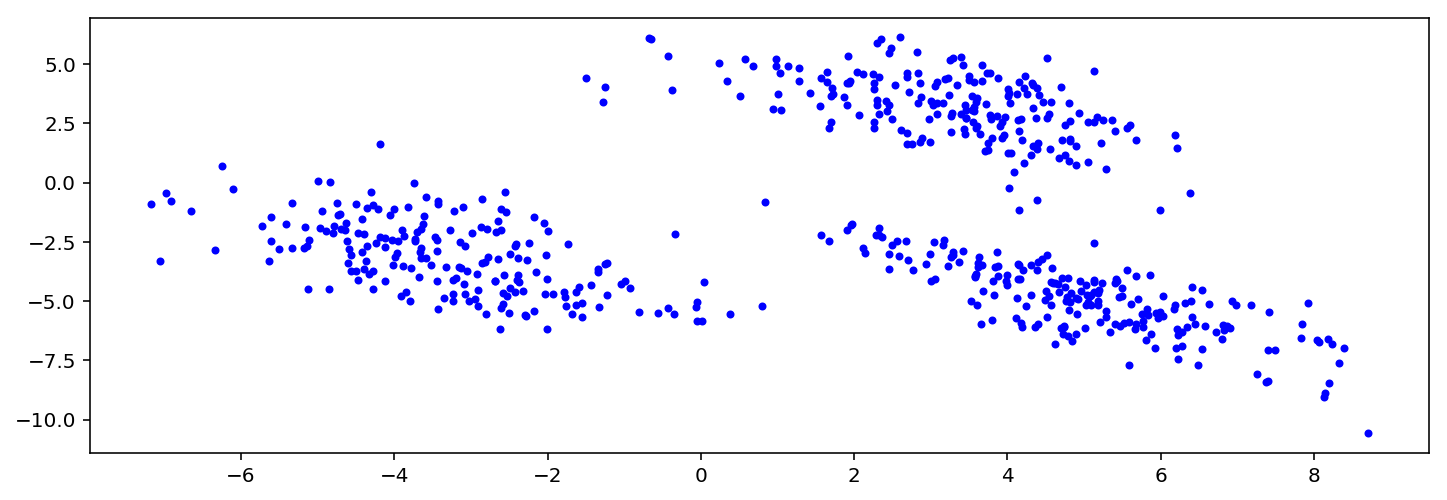

In [ ]:
# Combine into one unlabeled dataset and shuffle
X_train_nolab = np.concatenate((X_train['a'].T, X_train['b'].T, X_train['c'].T))
np.random.shuffle(X_train_nolab)
X_train_nolab = X_train_nolab.T
display(X_train_nolab.shape)
plt.plot(X_train_nolab[0,:], X_train_nolab[1,:], 'b.')
plt.show()

# Learn features
- Fit SKM centroids from the unlabeled version of the training data
- This produces an over-complete basis that we will use for the classification feature vectors

CPU times: user 3.91 ms, sys: 765 µs, total: 4.68 ms
Wall time: 4 ms


'Fitted centroids:'

(2, 10)

array([[ 0.112, -0.279, -0.543, -0.768,  0.804, -0.992,  0.914, -0.921,  0.499, -0.174],
       [ 0.994,  0.96 , -0.84 , -0.64 , -0.595, -0.124, -0.407, -0.391,  0.867, -0.985]])

'Fitted whitening PCA:'

PCA(copy=False, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

array([[ 0.966, -0.257],
       [ 0.257,  0.966]])

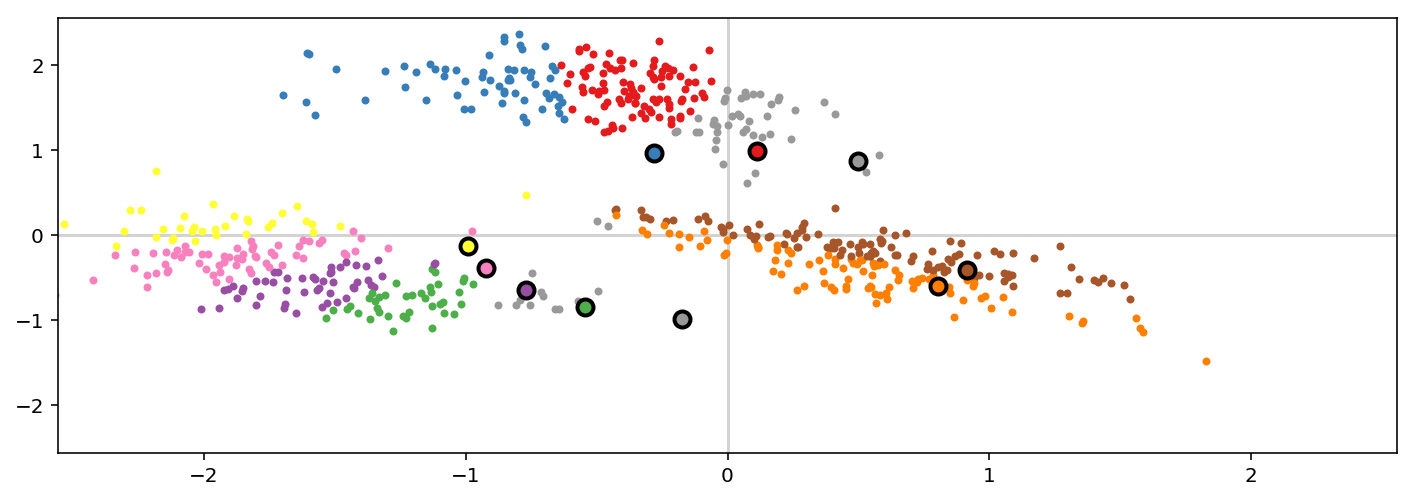

In [ ]:
skm = SKM(
    k=10,
    # variance_explained=0.99,
    # max_epocs=100,
    # assignment_change_eps=0.01,
    # standardize=False,
    # normalize=False,
    # do_pca=True,
    # pca_whiten=True,
    # visualize=False,
)

%time skm.fit(X_train_nolab)
display(
    'Fitted centroids:',
    skm.D.shape,
    skm.D,
    'Fitted whitening PCA:',
    skm.pca,
    skm.pca.components_,
)

skm_visualize_clusters(skm, X_train_nolab)
plt.show()


# Inspect the PCA whitening that SKM just did
- Whiten = decorrelate + standardize

In [ ]:
# Redo the whitening from skm.fit
X_train_nolab_white = skm.pca.transform(X_train_nolab.T).T

array([[15.066, -0.204],
       [-0.204, 14.351]])

array([[ 1.000e+00, -1.334e-17],
       [-1.334e-17,  1.000e+00]])

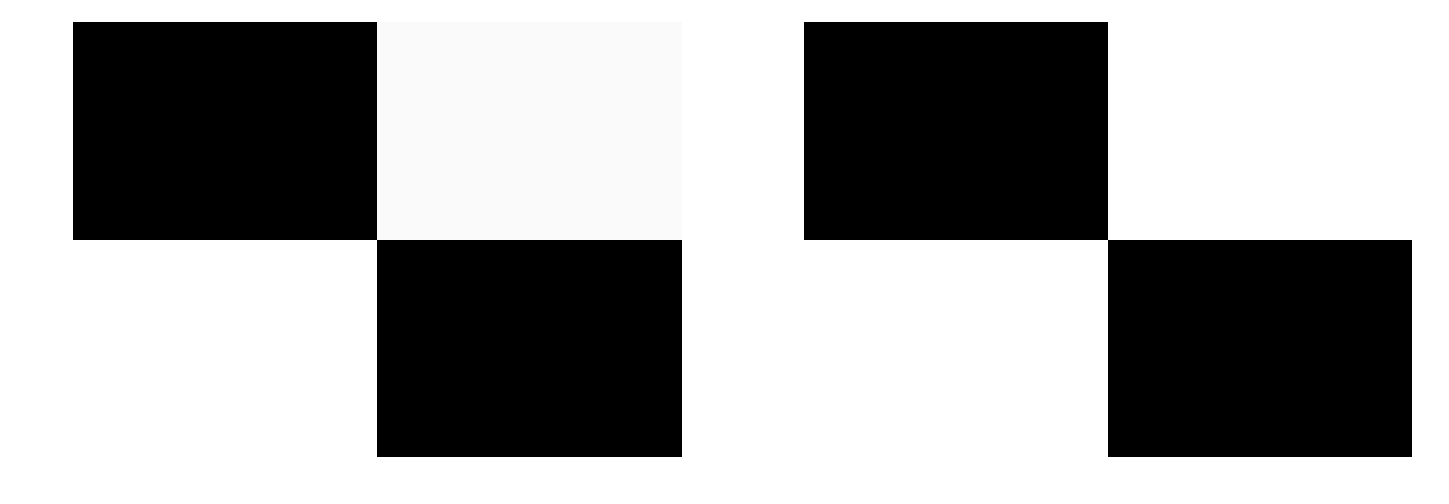

In [ ]:
# The whitened feature cov matrix should be ~I
for subplot, X in [
    (121, np.cov(X_train_nolab)),
    (122, np.cov(X_train_nolab_white)),
]:
    display(X)
    plt.subplot(subplot)
    plt.pcolormesh(X, cmap=mpl.cm.Greys_r)
    plt.axis('off')
plt.show()

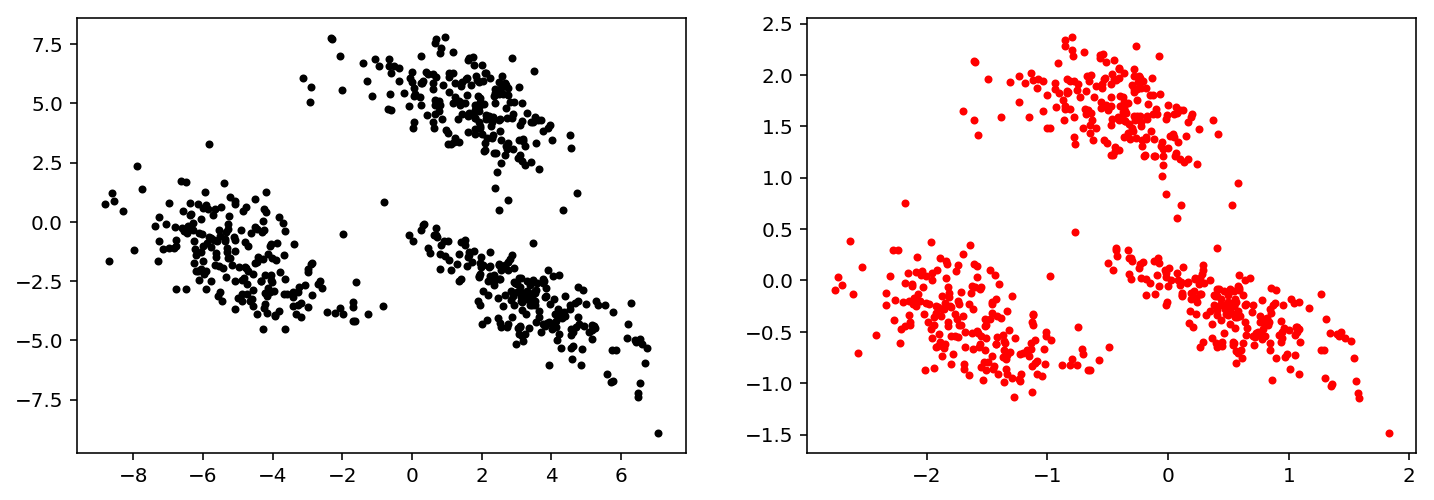

In [ ]:
# The whitened data should have "balanced" feature dimensions
plt.subplot(121); plt.plot(X_train_nolab[0,:], X_train_nolab[1,:], 'k.')
plt.subplot(122); plt.plot(X_train_nolab_white[0,:], X_train_nolab_white[1,:], 'r.')
plt.show()

# Project test data onto the fitted skm centroids

(2, 200)

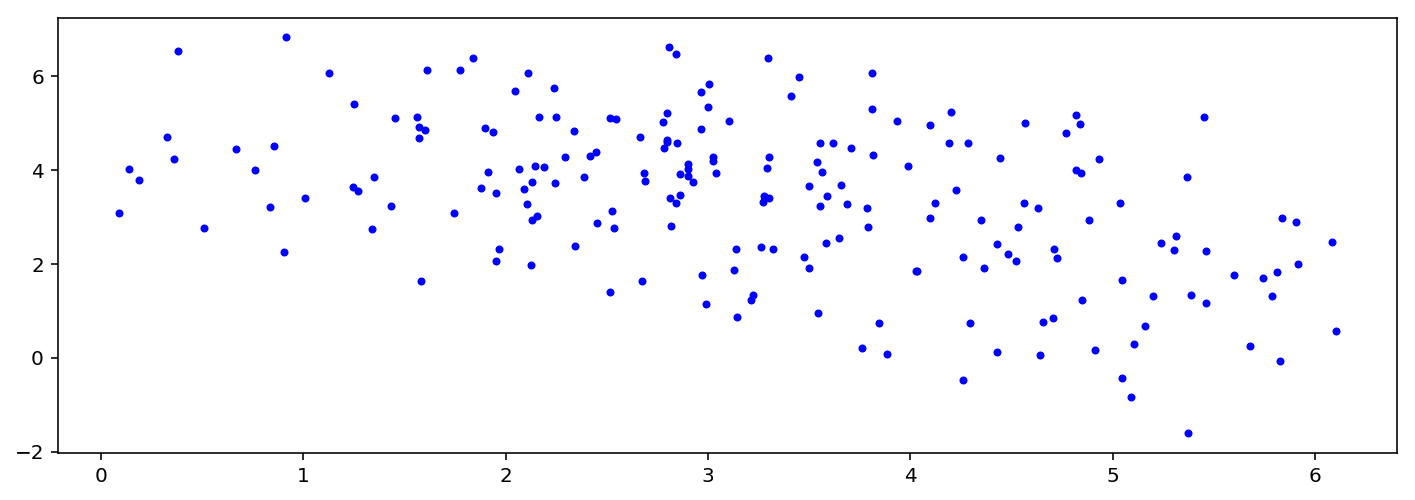

In [ ]:
# Generate some test data
X_test = np.array(polar_to_cart(
    r=5 + np.random.normal(size=200, scale=1),
    theta=np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0),
))
display(X_test.shape)
plt.plot(X_test[0], X_test[1], 'b.')
plt.show()

(2, 200)

(10, 200)

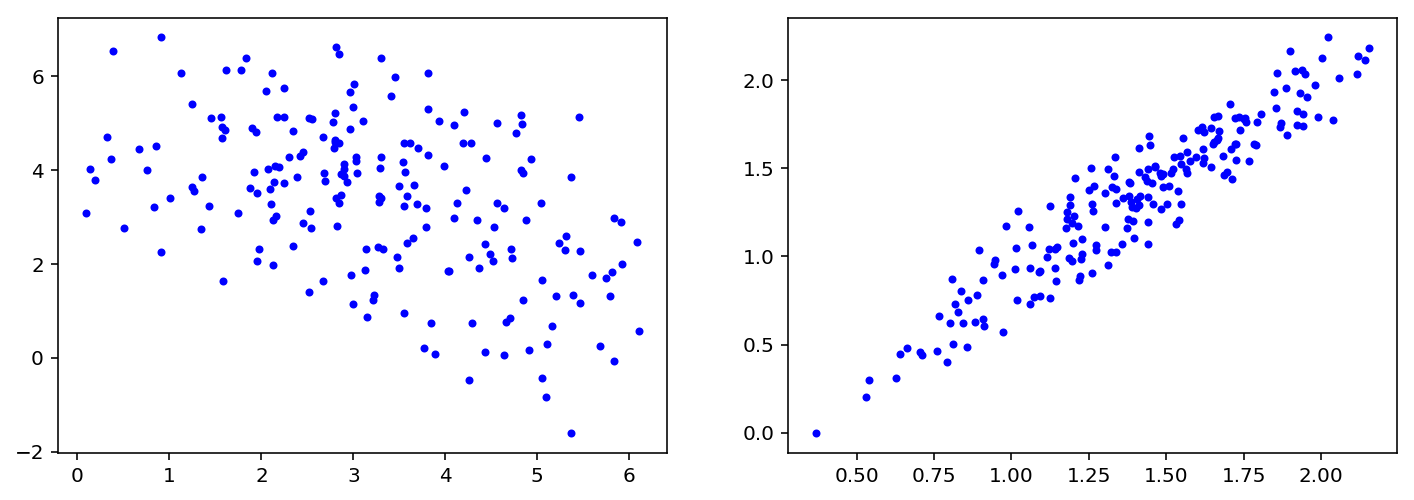

In [ ]:
# Project the test data using skm.transform, which:
#   - PCA whitens the test data, using the learned PCA from the (unlabeled) training data
#   - Projects the test data to the learned dictionary skm.D (i.e. the cluster centroids)
X_test_proj = skm.transform(X_test)
display(
    X_test.shape,  # n_freqs x n_patches
    X_test_proj.shape,  # n_centroids x n_patches
)
plt.subplot(121); plt.plot(X_test[0], X_test[1], 'b.')  # All 2 freq dims of the test data
plt.subplot(122); plt.plot(X_test_proj[0], X_test_proj[1], 'b.')  # Just the first two dims of X_test_proj (= first 2 PCs)
plt.show()

In [ ]:
# Aggregate the patches (= time = samples) dimension for each cluster centroid (= over-completion of freqs)
#   - Reduces dimensionality
#   - Forgets time structure (we don't need to mess with alignment -- but we do lose sequential structure of songs)

def agg_over_time(X: 'np.ndarray[n_centroids, n_patches]', aggs: List[str]) -> 'pd.DataFrame[n_centroids, n_aggs]':
    '''
    Aggregate each centroid row X[i,:] using each agg function ('mean', 'std', 'min', 'max', etc.)
    '''
    return pd.DataFrame(OrderedDict({
        agg: {
            'mean':     lambda X: np.mean(X, axis=1),
            'std':      lambda X: np.std(X, axis=1),
            'min':      lambda X: np.min(X, axis=1),
            'max':      lambda X: np.max(X, axis=1),
            'median':   lambda X: np.median(X, axis=1),
            'skewness': lambda X: scipy.stats.skew(X, axis=1),
            'kurtosis': lambda X: scipy.stats.kurtosis(X, axis=1),
            'dmean':    lambda X: np.mean(np.diff(X, axis=1), axis=1),
            'dstd':     lambda X: np.std(np.diff(X, axis=1), axis=1),
            'dmean2':   lambda X: np.mean(np.diff(np.diff(X, axis=1), axis=1), axis=1),
            'dstd2':    lambda X: np.std(np.diff(np.diff(X, axis=1), axis=1), axis=1),
        }[agg](X)
        for agg in aggs
    }))

# A friendly df of the aggregated centroid features [make tidy?]
#   - (n_centroids, n_patches) -> (n_centroids, n_aggs)
X_test_proj_agg_df = agg_over_time(X_test_proj, [
    'mean',
    'std',
    'max',
])

# The raw feature vector, which should finally be amenable to vanilla classification
#   - (n_centroids, n_patches) -> (n_centroids * n_aggs,)
X_test_proj_agg_flat = X_test_proj_agg_df.T.values.flatten()

display(
    X_test_proj.shape,
    X_test_proj_agg_df.shape,
    X_test_proj_agg_df,
    X_test_proj_agg_flat.shape,
    X_test_proj_agg_flat,
)

(10, 200)

(10, 3)

,mean,std,max
0,1.393,0.368,2.156
1,1.318,0.443,2.242
2,-1.209,0.296,-0.550
3,-0.947,0.296,-0.171
4,-0.771,0.490,0.583
5,-0.244,0.392,0.599
6,-0.501,0.477,0.735
7,-0.611,0.337,0.211
8,1.244,0.300,1.977
9,-1.385,0.356,-0.424


(30, )

array([ 1.393,  1.318, -1.209, -0.947, -0.771, -0.244, -0.501, -0.611,  1.244, -1.385,  0.368,  0.443,  0.296,  0.296,
        0.49 ,  0.392,  0.477,  0.337,  0.3  ,  0.356,  2.156,  2.242, -0.55 , -0.171,  0.583,  0.599,  0.735,  0.211,
        1.977, -0.424])